# Introduction

A variation on neural networks is the convolution neural network.  The convolution neural network replaces one or more layers of perceptrons with a convolution layers.  What is a convolution layer?

Mathematically a convolution is defined as

\begin{equation}
(f*g)(t) = \int_{-\infty}^\infty f(t-x)g(x)\mathrm{d}x
\end{equation}

How does this look in a neural network,  why do we want a convolution and what does it do for us.

At an abstract level, the convolution layer was designed to mimic how animals actually see. Hubel and Wiesel's experiments on cats and monkeys showed that many neurons in the visual cortex have a *small local* receptive field.  That is, they react only to components in a small subset of the receptive field. A convolution layer is used to represent this. 

The code below tries to plot convolution for us. There are better visualizations on the wikipedia page: https://en.wikipedia.org/wiki/Convolution#Visual_explanation

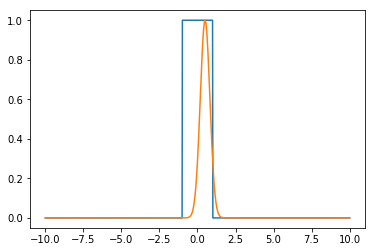

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-10,10,1000)
f1 = np.piecewise(x, [x< -1, x>=-1], [0, 1])
f2 = np.piecewise(x, [x<1, x>=1], [1, 0])
f = f1*f2
g = np.exp(-1*np.multiply(x-.5,x-.5)/.2)
plt.plot(x,f)
plt.hold
plt.plot(x,g)
plt.show()


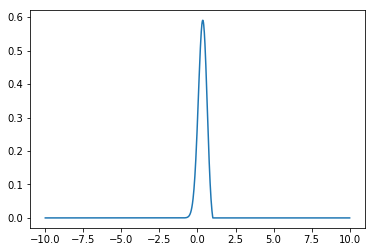

In [3]:
## Plot convolution
def convolution(x,f,g):
    #input domiain, function 1, function 2
    assert x.shape == f.shape
    assert x.shape == g.shape
    n = f.shape
    #print(n[0])
    h = np.zeros(f.shape)
    for i in range(0,n[0]):
        for j in range(i,n[0]):
            if j > 0:
                h[i] = h[i] + f[j-i]*g[i]*(x[j]-x[j-1])
            else:
                h[i] = h[i] + f[j-i]*g[i]*(x[j+1]-x[j])
        #print(h[i])
    return h

h = convolution(x,f,g)
#print(h)
plt.plot(x,h)
#plt.hold
#plt.plot(x,convolution(x,g,f))
plt.show()

A convolution layer is simply a layer which uses a convolution of local points in place of general multiplication in atleast one of the layers (frequently one of the first layers).
Convolution layers only work for grid topologies e.g 1D time series analysis or 2D images.

Convolutions look different in machine learning than they might in mathematics.  If 
\begin{equation}
s(t) = (x*w)(t)
\end{equation}
is our convolution then $x$ is referred to as the input and $w$ is referred to as the kernel.  We also have discrete values rather than a continuous values so our integral is replaced with a sum e.g.
\begin{equation}
S(i,j) = (I*K)(i,j) = \sum_m \sum_n I(m,n)K(i-m,j-n)
\end{equation}
Because convolution is communitive, we can write
\begin{equation}
S(i,j) = (K*I)(i,j) = \sum_m \sum_n K(m,n)I(i-m,j-n))
\end{equation}

Typically the kernel will only have support over a small range of values (which is what gives the localness).  More precisely, typically we will specify the size of the kernel and then our optimization algorithm will predict the values.

Example of convolution: edge detection.
![title](dog.png)
 The image on the right was formed by taking
each pixel in the original image and subtracting the value of its neighboring pixel on
the left. Image from Deep Learning by Goodfellow et-al, Chapter 9.

## Example Problem
Once again we will use the MNIST data. And use tensorflow to create a simple convolution neural network.


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("PACKAGES LOADED")

PACKAGES LOADED


In [5]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("Data ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Data ready


Our network is going to consist of one convolution layers followed by pooling and then dense (or normal) neuron layer.  Additionally we use a rectifier (ReLu) function on the convolution layers which is given by
\begin{equation}
f(x) = \mathrm{max}(0,x) \approx \mathrm{log}(1+\mathrm{e}^x)
\end{equation}

In [6]:
n_input  = 784  #Number of inputs
n_output = 10 #Number of outputs
weights  = {
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64], stddev=0.1)),  #weights for convolution layer, filter shape: [filter_height, filter_width, in_channels, out_channels]
    'wd1': tf.Variable(tf.random_normal([14*14*64, n_output], stddev=0.1)) #weights for neuron layer number of outputs from the convolution layer(64) * 14
}
biases   = {
    'bc1': tf.Variable(tf.random_normal([64], stddev=0.1)), #biases for convolution layer
    'bd1': tf.Variable(tf.random_normal([n_output], stddev=0.1)) #baises for neuron layer
}
def conv_simple(_input, _w, _b):
    # Reshape input into 2D grid to apply convolution
    _input_r = tf.reshape(_input, shape=[-1, 28, 28, 1])
    # Convolution
    _conv1 = tf.nn.conv2d(_input_r, _w['wc1'], strides=[1, 1, 1, 1], padding='SAME')  
    #computes a 2D convolution given 4-d input tensor and 4-d filter _w
    #input tensor shape : [batch, in_height, in_width, in_channels]
    #Filter of shape [filter_height, filter_width, in_channels, out_channels]
    # Performs
    # 1.) Flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels].
    # 2.) Extracts image patches from the input tensor to form a virtual tensor of shape [batch, out_height, out_width, filter_height * filter_width * in_channels].
    # 3.) For each patch, right-multiplies the filter matrix and the image patch vector.
    # strides - defines that the next element of the array is one unit away from the previous
    # Add-bias
    _conv2 = tf.nn.bias_add(_conv1, _b['bc1'])
    #adds bias to convolution
    # Pass ReLu
    _conv3 = tf.nn.relu(_conv2)
    #Applies ReLu activation to convolution + bias
    # Max-pooling
    _pool  = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #Takes max value from _conv3, ksize defines the size of each window(2.2) 
    # while strides tells us how to shift the pool middle to find the next window to pool
    # Vectorize
    _dense = tf.reshape(_pool, [-1, _w['wd1'].get_shape().as_list()[0]])
    #Reshape matrix to be a vector
    # Fully-connected layer
    _out = tf.add(tf.matmul(_dense, _w['wd1']), _b['bd1'])
    #add ins in a layer of normal neural network
    # Return everything, creates dictionary so that intermediate steps are available for us to inspect later, if desired.
    out = {
        'input_r': _input_r, 'conv1': _conv1, 'conv2': _conv2, 'conv3': _conv3
        , 'pool': _pool, 'dense': _dense, 'out': _out
    }
    return out
print ("CNN ready")

CNN ready


## Define Computational Graph

In [7]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
# Parameters
learning_rate   = 0.001
training_epochs = 10
batch_size      = 100
display_step    = 1
# Functions! 
#with tf.device(device_type): # <= This is optional
_pred = conv_simple(x, weights, biases)['out']
try: 
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = _pred, labels= y))
except:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = _pred, labels=y)) 
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) #Sets up optimizer
_corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
init = tf.global_variables_initializer()
# Saver 
save_step = 1;
savedir = "nets/"
saver = tf.train.Saver(max_to_keep=3) 
print ("Network Ready to Go!")

Network Ready to Go!


## Optimize

In [8]:
do_train = 0
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)


In [9]:
if do_train == 1:
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print( "Total Batch: %03d" %(total_batch))
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training accuracy: %.3f" % (train_acc))
            test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel})
            print (" Test accuracy: %.3f" % (test_acc))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("Optimization Finished.")

## Restore

In [19]:
if do_train == 0:
    epoch = training_epochs-1
    saver.restore(sess, "nets/cnn_mnist_simple.ckpt-" + str(epoch))
    print ("NETWORK RESTORED")

INFO:tensorflow:Restoring parameters from nets/cnn_mnist_simple.ckpt-9
NETWORK RESTORED


## Investigating the innner workings of the CNN

In [20]:

conv_out = conv_simple(x, weights, biases)
input_r = sess.run(conv_out['input_r'], feed_dict={x: trainimg[0:1, :]})
conv1   = sess.run(conv_out['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2   = sess.run(conv_out['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3   = sess.run(conv_out['conv3'], feed_dict={x: trainimg[0:1, :]})
pool    = sess.run(conv_out['pool'], feed_dict={x: trainimg[0:1, :]})
dense   = sess.run(conv_out['dense'], feed_dict={x: trainimg[0:1, :]})
out     = sess.run(conv_out['out'], feed_dict={x: trainimg[0:1, :]})


# View Input

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


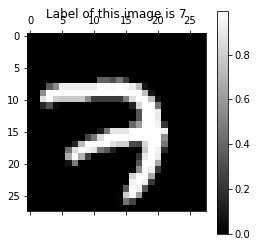

In [12]:
# Let's see 'input_r'
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# Plot ! 
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

# Check Convolution

Size of 'conv1' is (1, 28, 28, 64)


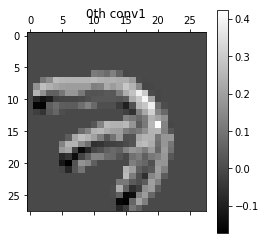

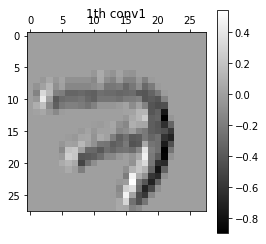

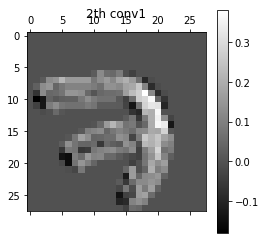

In [13]:
# Let's see 'conv1'
print ("Size of 'conv1' is %s" % (conv1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show()

# Convolution + Bias

Size of 'conv2' is (1, 28, 28, 64)


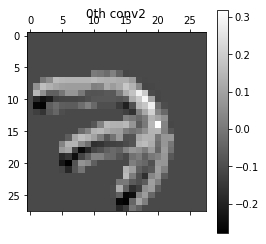

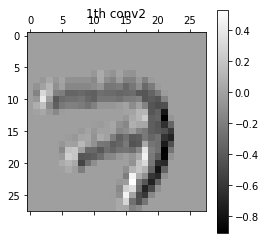

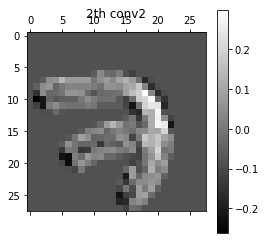

In [14]:


# Let's see 'conv2'
print ("Size of 'conv2' is %s" % (conv2.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show()



# Convolution + Bias + Activation

Size of 'conv3' is (1, 28, 28, 64)


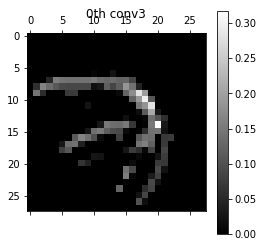

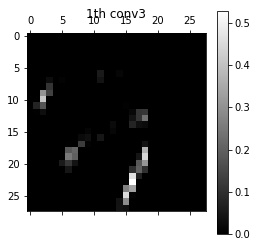

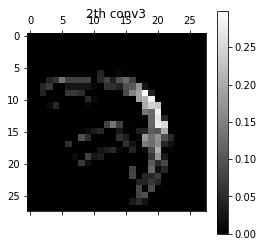

In [15]:
# Let's see 'conv3'
print ("Size of 'conv3' is %s" % (conv3.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show()

# Pool

Size of 'pool' is (1, 14, 14, 64)


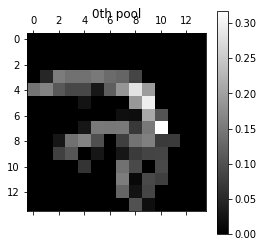

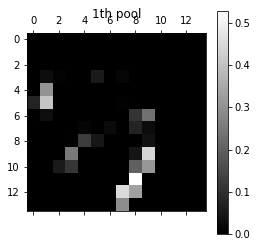

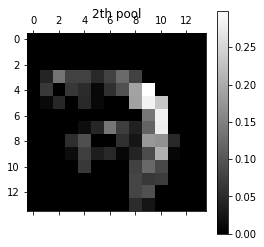

In [16]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show()


# Dense network

In [17]:
# Let's see 'dense'
print ("Size of 'dense' is %s" % (dense.shape,))
# Let's see 'out'
print ("Size of 'out' is %s" % (out.shape,))



Size of 'dense' is (1, 12544)
Size of 'out' is (1, 10)


# Visualizing the convolution filters

Size of 'wc1' is (3, 3, 1, 64)


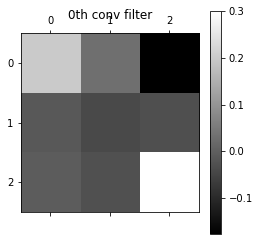

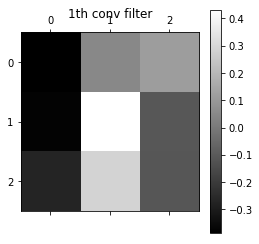

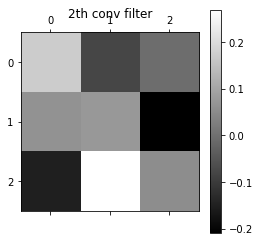

In [18]:
# Let's see weight! 
wc1 = sess.run(weights['wc1'])
print ("Size of 'wc1' is %s" % (wc1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show()

# Bibliography

Code https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/cnn_mnist_simple.ipynb
added some comments
Background: http://www.deeplearningbook.org/contents/convnets.html, Hands on Machine Learning with Scikit-Learn and Tensorflow by Aurelien Geron